In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import os
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import cv2

2024-07-08 09:01:51.356431: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-08 09:01:51.356538: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-08 09:01:51.484379: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
DATA_INPUT_PATH = "/kaggle/input/iam-handwriting-word-database"

images_path = []
labels = []

def preprocess_dataset():
    characters = set()
    max_len = 0
    k=0
    with open(os.path.join(DATA_INPUT_PATH, 'words_new.txt'), 'r') as file:
        lines = file.readlines()

        for line_number, line in enumerate(lines):
            # Skip comments and empty lines
            if line.startswith('#') or line.strip() == '':
                continue

            # Split the line and extract information
            parts = line.strip().split()
            ok_chk=parts[1]

            # Continue with the rest of the code
            word_id = parts[0] 
            if ok_chk=="ok":
               k=k+1

               first_folder = word_id.split("-")[0]
               second_folder = first_folder + '-' + word_id.split("-")[1]

            # Construct the image filename
               image_filename = f"{word_id}.png"
               image_path = os.path.join(
                DATA_INPUT_PATH, 'iam_words', 'words', first_folder, second_folder, image_filename)

            # Check if the image file exists
               if os.path.isfile(image_path) and os.path.getsize(image_path):

                 images_path.append(image_path)

                # Extract labels
                 label = parts[-1].strip()
                 for char in label:
                    characters.add(char)

                 max_len = max(max_len, len(label))
                 labels.append(label)

    characters = sorted(list(characters))

    print('characters: ', characters)
    print('max_len: ', max_len)
    print('total valid file: ',k)
    # Mapping characters to integers.
    char_to_num = tf.keras.layers.StringLookup(
        vocabulary=list(characters), mask_token=None)

    # Mapping integers back to original characters.
    num_to_char = tf.keras.layers.StringLookup(
        vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
    )
    return characters, char_to_num, num_to_char, max_len
    
characters, char_to_num, num_to_char, max_len = preprocess_dataset()

characters:  ['!', '"', '#', "'", '(', ')', '*', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
max_len:  19
total valid file:  38305


In [4]:
IMAGE_SIZE = (32,128)
PADDING_TOKEN = 99
BATCH_SIZE=32

(32, 128, 1)


(-0.5, 127.5, 31.5, -0.5)

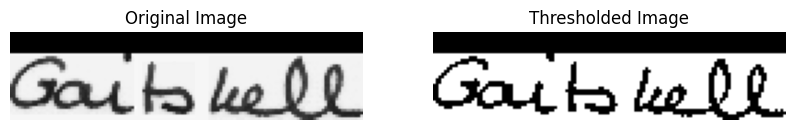

In [7]:
    image = tf.io.read_file(images_path[5])
    image = tf.image.decode_png(image,  channels=1)
    new_w = 128
    new_h = 32
    image = tf.image.resize(image, size=(new_h, new_w),method=tf.image.ResizeMethod.BICUBIC, preserve_aspect_ratio=True)
    h= tf.shape(image)[0]
    w=tf.shape(image)[1]

    if h<32:
       padding_h=abs(new_h-h)
    else:
       padding_h=0
    if w<128:
       padding_w=new_w-w
    else:
       padding_w=0

    image = tf.pad(
        image,
        paddings=[
            [padding_h,0],
            [padding_w,0],
            [0,0],
        ],
    )
    thresholded_image = tf.where(image > 127.0, 255.0, 0.0)
    print(thresholded_image.shape)
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(image, cmap='gray')
    axs[0].set_title('Original Image')
    axs[0].axis('off')

    axs[1].imshow(thresholded_image, cmap='gray')
    axs[1].set_title('Thresholded Image')
    axs[1].axis('off')


In [7]:
def process_image(image):
    new_w = 128
    new_h = 32
    image = tf.image.resize(image, size=(new_h, new_w),method=tf.image.ResizeMethod.BICUBIC, preserve_aspect_ratio=True)
    h= tf.shape(image)[0]
    w=tf.shape(image)[1]

    if h<32:
       padding_h=abs(new_h-h)
    else:
       padding_h=0
    if w<128:
       padding_w=new_w-w
    else:
       padding_w=0

    image = tf.pad(
        image,
        paddings=[
            [padding_h,0],
            [padding_w,0],
            [0,0],
        ],
    )
    image = tf.where(image > 200.0, 255.0, 0.0)

    return image
    
def vectorize_label(label):
    label = char_to_num(tf.strings.unicode_split(
        label, input_encoding="UTF-8"))
    length = tf.shape(label)[0]
    pad_amount = max_len - length
    label = tf.pad(label, paddings=[[0, pad_amount]],
                   constant_values=PADDING_TOKEN)
    return label
def process(image_path, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image,  channels=1)
    image = process_image(image)
    image = tf.cast(image, tf.float32)/255.0 
    
    label = vectorize_label(label)  
    return {"image": image, "label": label}
def prepare_dataset(images_files, images_labels):
    
    dataset = tf.data.Dataset.from_tensor_slices((images_files, images_labels))
    dataset = dataset.map(process, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)
    return dataset


In [8]:
def split_dataset():
    # Split the data into training, validation, and test sets using train_test_split
    train_images, test_images, train_labels, test_labels = train_test_split(
        images_path, labels, test_size=0.2, random_state=42
    )

    # Further split the test set into validation and final test sets
    val_images, test_images, val_labels, test_labels = train_test_split(
        test_images, test_labels, test_size=0.5, random_state=42
    )

    train_set = prepare_dataset(train_images, train_labels)
    val_set = prepare_dataset(val_images, val_labels)
    test_set = prepare_dataset(test_images, test_labels)
    print(len(train_images))
    print(len(val_labels))
    print(len(test_labels))
    print("Train df: \n",train_set)
    print("Test df: \n",test_set)
    print("Val df: \n",val_set)
    return train_set, val_set, test_set

train_set, val_set, test_set = split_dataset()

30643
3830
3831
Train df: 
 <_PrefetchDataset element_spec={'image': TensorSpec(shape=(None, None, None, 1), dtype=tf.float32, name=None), 'label': TensorSpec(shape=(None, None), dtype=tf.int64, name=None)}>
Test df: 
 <_PrefetchDataset element_spec={'image': TensorSpec(shape=(None, None, None, 1), dtype=tf.float32, name=None), 'label': TensorSpec(shape=(None, None), dtype=tf.int64, name=None)}>
Val df: 
 <_PrefetchDataset element_spec={'image': TensorSpec(shape=(None, None, None, 1), dtype=tf.float32, name=None), 'label': TensorSpec(shape=(None, None), dtype=tf.int64, name=None)}>


(32, 128, 1)
(32, 128, 1)
(32, 128, 1)
(32, 128, 1)
(32, 128, 1)
(32, 128, 1)
(32, 128, 1)
(32, 128, 1)
(32, 128, 1)
(32, 128, 1)
(32, 128, 1)
(32, 128, 1)
(32, 128, 1)
(32, 128, 1)
(32, 128, 1)
(32, 128, 1)


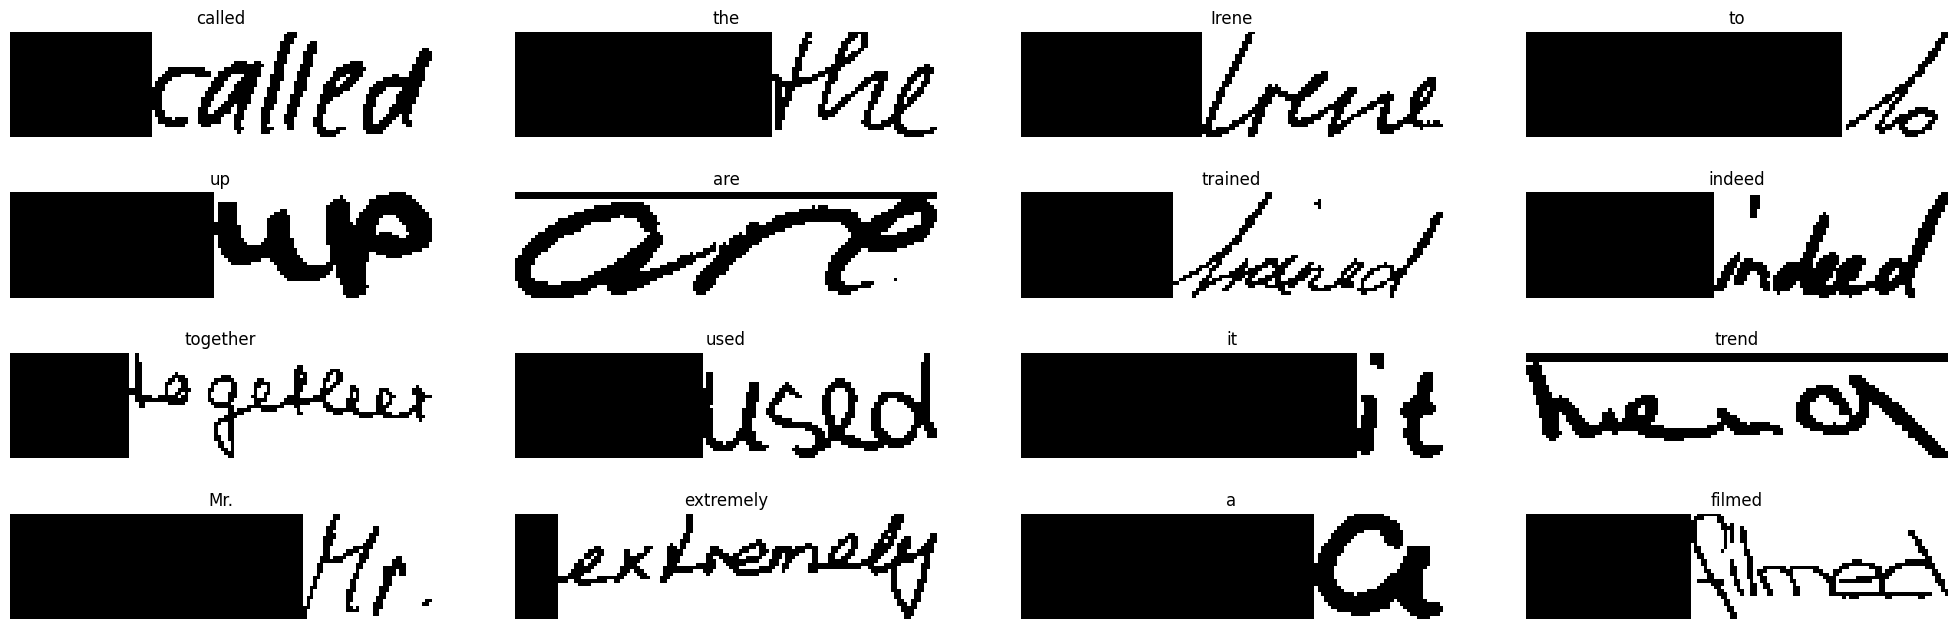

In [23]:
FIGSIZE=(25, 8)
GRID=[4,4]
plt.figure(figsize=FIGSIZE)
n_rows, n_cols = GRID
    
    # Loading Data 
data = next(iter(test_set))
images, img_labels = data['image'], data['label']


    
    # Iterate over the data 
for index,(image, label) in enumerate(zip(images, img_labels)):
        if index==(n_rows*n_cols):
            break
        
        # Label processing
        text_label = num_to_char(label)
        text_label = tf.strings.reduce_join(text_label).numpy().decode('UTF-8')
        text_label = text_label.replace("[UNK]", " ").strip()
        print(image.shape)
        
        # Create a sub plot
        plt.subplot(n_rows, n_cols, index+1)
        plt.imshow(image,cmap='binary_r')
        plt.axis('off')
        plt.title(text_label)

In [11]:
import tensorflow as tf
import tensorflow.data as tfd
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint 

In [9]:
class CTCLayer(tf.keras.layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = tf.keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * \
            tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * \
            tf.ones(shape=(batch_len, 1), dtype="int64")
        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions.
        return y_pred

In [17]:
def build_model():
    input_img = tf.keras.Input(
        shape=(32, 128, 1), name="image")
    labels = tf.keras.layers.Input(name="label", shape=(None,))

    x = tf.keras.layers.Conv2D(
        32,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
    )(input_img)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    x = tf.keras.layers.Conv2D(
        64,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
    )(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    new_shape = ((128 // 4), (32 // 4) * 64)
    x = tf.keras.layers.Reshape(target_shape=new_shape)(x)
    x = tf.keras.layers.Dense(64, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(128, return_sequences=True, dropout=0.25)
    )(x)
    x = tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(64, return_sequences=True, dropout=0.25)
    )(x)
    x = tf.keras.layers.Dense(
        len(char_to_num.get_vocabulary()) + 2, activation="softmax", name="dense2"
    )(x)
    output = CTCLayer(name="ctc_loss")(labels, x)
    model = tf.keras.models.Model(
        inputs=[input_img, labels], outputs=output
    )
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
    model.summary()
    return model
    
model = build_model()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image (InputLayer)  │ (None, 32, 128,   │          0 │ -                 │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 128,   │        320 │ image[0][0]       │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 16, 64,    │          0 │ conv2d_4[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 16, 64,    │     18,496 │ max_pooling2d_4[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 8, 32, 64) │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_2 (Reshape) │ (None, 32, 512)   │          0 │ max_pooling2d_5[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 32, 64)    │     32,832 │ reshape_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 32, 64)    │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_2     │ (None, 32, 256)   │    197,632 │ dropout_1[0][0]   │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_3     │ (None, 32, 128)   │    164,352 │ bidirectional_2[… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ label (InputLayer)  │ (None, None)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense2 (Dense)      │ (None, 32, 79)    │     10,191 │ bidirectional_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ctc_loss (CTCLayer) │ (None, 32, 79)    │          0 │ label[0][0],      │
│                     │                   │            │ dense2[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 423,823 (1.62 MB)

 Trainable params: 423,823 (1.62 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
pip install jiwer

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 33.4 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [11]:
from tensorflow import keras
from tensorflow.keras import layers
#from jiwer import wer
from IPython import display
from tensorflow.keras.callbacks import Callback



In [12]:
def wer_man(reference, hypothesis):
  """
  Calculates the Word Error Rate (WER) between a reference sequence and a hypothesis sequence.

  Args:
      reference: A string representing the ground truth text (including punctuation).
      hypothesis: A string representing the predicted text (including punctuation).

  Returns:
      A float value between 0 and 1 representing the WER.
  """
  # Ensure reference and hypothesis are lowercase for case-insensitive comparison
  reference = reference.lower()
  hypothesis = hypothesis.lower()

  # Add 1 to avoid division by zero
  n = len(reference) + 1
  m = len(hypothesis) + 1

  # Create a distance matrix
  d = np.zeros((n, m))

  # Initialize the first row and column with insertion costs
  for i in range(1, n):
    d[i, 0] = i
  for j in range(1, m):
    d[0, j] = j

  # Fill the distance matrix using Levenshtein distance algorithm
  for i in range(1, n):
    for j in range(1, m):
      if reference[i - 1] == hypothesis[j - 1]:
        cost = 0
      else:
        cost = 1
      d[i, j] = min(d[i - 1, j] + 1,  # Insertion
                    d[i, j - 1] + 1,  # Deletion
                    d[i - 1, j - 1] + cost)  # Substitution

  # WER is the normalized Levenshtein distance
  #print(d[n-1,m-1])
  wer = d[n - 1, m - 1] / max(len(reference), len(hypothesis))
  return wer



In [18]:

def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    results = tf.keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0]
    output_text = []
    #for result in results:
     #   result = tf.gather(result, tf.where(tf.math.not_equal(result, -1)))
      #  result = tf.strings.reduce_join(num_to_char(result)).numpy().decode("utf-8")
      #  output_text.append(result)
    for result in results:
         text_label = num_to_char(result)
         text_label = tf.strings.reduce_join(text_label).numpy().decode('UTF-8')
         text_label = text_label.replace("[UNK]", " ").strip()
         output_text.append(text_label)
        
    return output_text


# A callback class to output a few transcriptions during training
class WerCallback(tf.keras.callbacks.Callback):
    """Displays a batch of outputs after every epoch."""

    def __init__(self, pred_model, validation_images, validation_labels):
        super().__init__()
        self.prediction_model = pred_model
        self.validation_images = validation_images
        self.validation_labels = validation_labels

    def on_epoch_end(self, epoch: int, logs=None):
        predictions = []
        targets = []
        wer_values = []
        for i in range(len(self.validation_images)):
            labels = self.validation_labels[i]
            #input_l = np.ones(labels.shape[0]) * labels.shape[1]
            
    # Use greedy search. For complex tasks, you can use beam search
            #res = tf.keras.backend.ctc_decode(labels, input_length=input_l, greedy=True)[0][0]
            #print(res)
            
            predictions = self.prediction_model.predict(
                self.validation_images[i])
            
            predictions = decode_batch_predictions(predictions)
            predictions.extend(predictions)
           
            
            for label in labels:
                text_label = num_to_char(label)
                text_label = tf.strings.reduce_join(text_label).numpy().decode('UTF-8')
                text_label = text_label.replace("[UNK]", " ").strip()
                targets.append(text_label)
            #print(predictions)
            for pred_text, target_text in zip(predictions, targets):
                #print(len(pred_text),len(target_text))
                wer_value = wer_man(target_text, pred_text)
                wer_values.append(wer_value)
            
            
                
        avg_wer = np.mean(wer_values)
        print(f"Epoch {epoch+1}: Average CER: {avg_wer:.4f}")
            #print(targets)
         

In [19]:
output_layer = model.get_layer(name="dense2").output
desired_input_index = 0  # Change this to 1 if the desired input comes from the second branch
input_tensors = [model.inputs[i] for i in range(len(model.inputs))]
#output_tensor = model.layers[concat_layer_index].inputs[desired_input_index]
print(desired_input_index)
#desired_branch_model = keras.Model(inputs=input_tensors[desired_input_index], outputs=model.get_layer("dense2").output )


# Create a new model with the specific input and output layers
prediction_model = keras.Model(inputs=input_tensors[desired_input_index], outputs=output_layer)

0


In [20]:
validation_images = []
validation_labels = []

for batch in val_set:
        validation_images.append(batch["image"])
        validation_labels.append(batch["label"])


#print(validation_images)
WER_callback = WerCallback(
        prediction_model,  validation_images, validation_labels)
early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=10, restore_best_weights=True
    )
history=model.fit(train_set,epochs=15,validation_data=val_set,callbacks=[WER_callback, early_stopping])


#WER_callback.on_epoch_end(1)


Epoch 1/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 569ms/stepstep - loss: 572.46
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━

In [28]:
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search.
    results = tf.keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_len
    ]
    

    # Iterate over the results and get back the text.
    output_text = []
    for res in results:
        res = tf.gather(res, tf.where(tf.math.not_equal(res, -1)))
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
        
    #print(output_text)    
    return output_text

correct=0
total=0
#  Let's check results on some test samples.
for batch in test_set.take(120):
    batch_images = batch["image"]
    batch_labels = batch["label"]

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)
    #print("Predict_Text -- Correct_label")
    pred_t=[]
    correct_t=[]
    for k in range(len(batch_images)):
        total=total+1
        lab= batch_labels[k]
        text_label1 = num_to_char(lab)
        text_label1 = tf.strings.reduce_join(text_label1).numpy().decode('UTF-8')
        text_label1 = text_label1.replace("[UNK]", " ").strip()
        
        if pred_texts[k]==text_label1:
            correct+=1
            pred_t.append(pred_texts[k])
            correct_t.append(text_label1)
            #print(pred_texts[k],text_label1)
    print("Pred_text: ",pred_t)
    print("Correct_text: ",correct_t)

print("Correct Text :",correct)
print("Total Text: ",total)
print('Correct words predicted      : %.2f%%' %(correct*100/total))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Pred_text:  ['the', 'to', 'up', 'Mr.', 'a', ',', 'Mr.', 'and', 'is', 'the', 'Mr.', 'Mr.']
Correct_text:  ['the', 'to', 'up', 'Mr.', 'a', ',', 'Mr.', 'and', 'is', 'the', 'Mr.', 'Mr.']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Pred_text:  ['that', 'It', ',', 'the', '.', 'the', 'is', 'with', 'that', ',']
Correct_text:  ['that', 'It', ',', 'the', '.', 'the', 'is', 'with', 'that', ',']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Pred_text:  ['the', 'a', ',', 'been', 'and', 'to', ',', 'Mr.']
Correct_text:  ['the', 'a', ',', 'been', 'and', 'to', ',', 'Mr.']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Pred_text:  ['.', 'the', 'of', 'of', '.', 'an', '"', 'to', 'in', 'the', 'The', '-']
Correct_text:  ['.', 'the', 'of', 'of', '.', 'an', '"', 'to', 'in', 'the', 'The', '-']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Pred_text:  ['has', 'The', 'his', 'it', 'the', 'the', 'in', 'and', 'the', 'with', 'the', ',', ',', 'the']
Correct_text:  ['has', 'The', 'his', 'it', 'the', 'the', 'in',

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


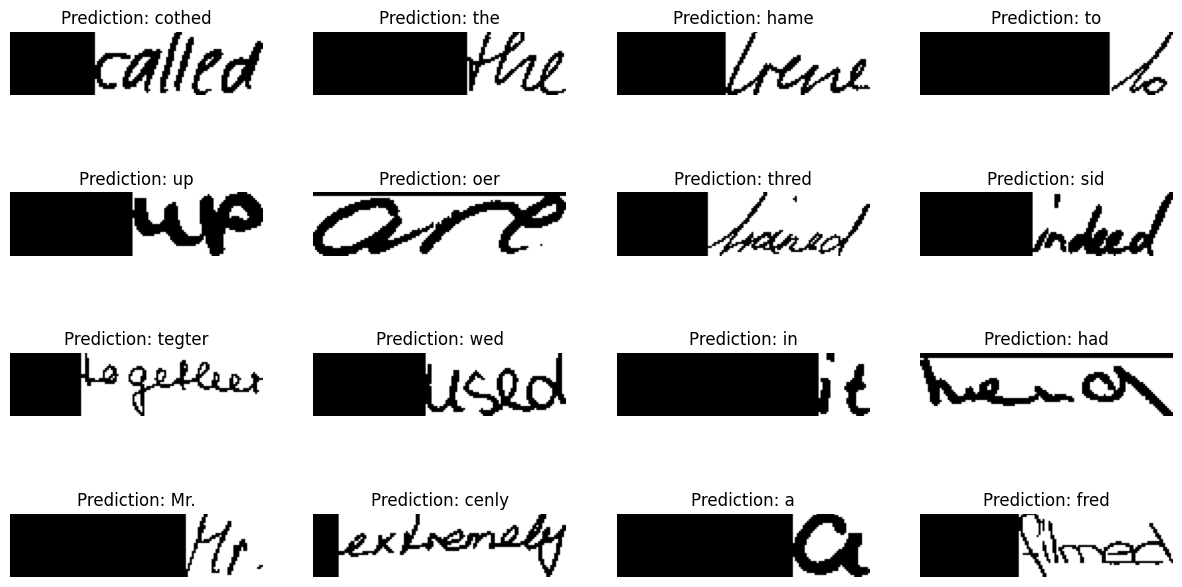

In [29]:
for batch in test_set.take(1):
    batch_images = batch["image"]
    batch_labels = batch["label"]
    _, ax = plt.subplots(4,4, figsize=(15, 8))
    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)
    for i in range(16):
        img = batch_images[i]
        lb= batch_labels[i]
        text_label = num_to_char(lb)
        text_label = tf.strings.reduce_join(text_label).numpy().decode('UTF-8')
        text_label = text_label.replace("[UNK]", " ").strip()
         
        #img = tf.image.flip_left_right(img)
        #img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]
        #print(text_label)
        title = f"Prediction: {pred_texts[i]}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")

plt.show()